In [41]:
!pip install mysql-connector-python
import mysql.connector

from sqlalchemy import create_engine
import pandas as pd


from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
import matplotlib.pyplot as plt

DB_USER = "root"
DB_PASS = "copra^outrage1"
DB_HOST = "localhost"         
DB_PORT = 3306
DB_NAME = "steam_db"

engine = create_engine(f"mysql+pymysql://{DB_USER}:{DB_PASS}@{DB_HOST}:{DB_PORT}/{DB_NAME}",
                       pool_pre_ping=True)

sql = "SELECT * FROM steam_games LIMIT 100000;"
df = pd.read_sql(sql, engine)

# Make sure 'price' exists and is numeric
df['Price'] = pd.to_numeric(df['Price'], errors='coerce')  # convert strings to numbers, NaN if invalid

# 1 = Free, 0 = Paid
df['is_free'] = df['Price'].apply(lambda x: 1 if x == 0 else 0)

# Check the counts
game_type_counts = df['is_free'].value_counts().rename({0: 'Paid', 1: 'Free'})
print("Total number of games by type:")
print(game_type_counts)


Total number of games by type:
is_free
Paid    79601
Free    20399
Name: count, dtype: int64


In [46]:

total_free = df['is_free'].sum()
total_paid = (df['is_free'] == 0).sum()


tags_counts['Free_pct'] = tags_counts['Free'] / total_free
tags_counts['Paid_pct'] = tags_counts['Paid'] / total_paid


tags_counts['Diff_pct'] = tags_counts['Free_pct'] - tags_counts['Paid_pct']


top_free_tags_pct = tags_counts.sort_values('Free_pct', ascending=False).head(20)


top_paid_tags_pct = tags_counts.sort_values('Paid_pct', ascending=False).head(20)

print("Top 20 tags in FREE games (by percentile):")
print(top_free_tags_pct[['Free_pct','Paid_pct','Diff_pct']])

print("\nTop 20 tags in PAID games (by percentile):")
print(top_paid_tags_pct[['Free_pct','Paid_pct','Diff_pct']])


Top 20 tags in FREE games (by percentile):
is_free                Free_pct  Paid_pct  Diff_pct
Indie                  0.234619  0.473725 -0.239106
Free to Play           0.186921  0.003555  0.183366
Action                 0.168244  0.343476 -0.175232
Casual                 0.144713  0.333438 -0.188725
Adventure              0.134418  0.328513 -0.194095
Singleplayer           0.122261  0.431929 -0.309668
Multiplayer            0.085004  0.083441  0.001563
Strategy               0.081278  0.163691 -0.082413
RPG                    0.075739  0.143327 -0.067588
Simulation             0.075053  0.164282 -0.089229
Early Access           0.065640  0.111707 -0.046067
2D                     0.061915  0.227535 -0.165620
VR                     0.055395  0.053328  0.002066
Massively Multiplayer  0.043434  0.010113  0.033321
Atmospheric            0.041816  0.145036 -0.103220
Shooter                0.035737  0.081054 -0.045317
First-Person           0.035737  0.101029 -0.065292
Puzzle               

In [45]:

tags_with_group = tags_encoded.join(df['is_free'])


tags_counts = tags_with_group.groupby('is_free').sum().T  # transpose to have tags as rows


cols_map = {}
if 0 in tags_counts.columns:
    cols_map[0] = 'Paid'
if 1 in tags_counts.columns:
    cols_map[1] = 'Free'
tags_counts = tags_counts.rename(columns=cols_map)


if 'Paid' not in tags_counts.columns:
    tags_counts['Paid'] = 0
if 'Free' not in tags_counts.columns:
    tags_counts['Free'] = 0


tags_counts['Diff'] = tags_counts['Free'] - tags_counts['Paid']


top_free_tags_count = tags_counts.sort_values('Free', ascending=False).head(20)


top_paid_tags_count = tags_counts.sort_values('Paid', ascending=False).head(20)

print("Top 20 tags in FREE games (by count, descending):")
print(top_free_tags_count[['Free','Paid','Diff']])

print("\nTop 20 tags in PAID games (by count, descending):")
print(top_paid_tags_count[['Free','Paid','Diff']])



Top 20 tags in FREE games (by count, descending):
is_free                Free   Paid   Diff
Indie                  4786  37709 -32923
Free to Play           3813    283   3530
Action                 3432  27341 -23909
Casual                 2952  26542 -23590
Adventure              2742  26150 -23408
Singleplayer           2494  34382 -31888
Multiplayer            1734   6642  -4908
Strategy               1658  13030 -11372
RPG                    1545  11409  -9864
Simulation             1531  13077 -11546
Early Access           1339   8892  -7553
2D                     1263  18112 -16849
VR                     1130   4245  -3115
Massively Multiplayer   886    805     81
Atmospheric             853  11545 -10692
Shooter                 729   6452  -5723
First-Person            729   8042  -7313
Puzzle                  728  11663 -10935
Story Rich              720   9240  -8520
3D                      698  11038 -10340

Top 20 tags in PAID games (by count, descending):
is_free         F

In [47]:

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix


X = tags_encoded.copy()
y = df['is_free']


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


rf = RandomForestClassifier(
    n_estimators=200,      
    max_depth=10,           
    random_state=42,
    n_jobs=-1               

rf.fit(X_train, y_train)


y_pred = rf.predict(X_test)

print("Classification Report:\n")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:\n")
print(confusion_matrix(y_test, y_pred))


importances = pd.Series(rf.feature_importances_, index=X.columns)
top_tags = importances.sort_values(ascending=False).head(20)

print("\nTop 20 tags most predictive of Free vs Paid games:\n")
print(top_tags)


Classification Report:

              precision    recall  f1-score   support

           0       0.81      1.00      0.89     15920
           1       0.98      0.06      0.11      4080

    accuracy                           0.81     20000
   macro avg       0.89      0.53      0.50     20000
weighted avg       0.84      0.81      0.73     20000

Confusion Matrix:

[[15916     4]
 [ 3850   230]]

Top 20 tags most predictive of Free vs Paid games:

Free to Play             0.253014
Singleplayer             0.098366
Indie                    0.056068
Casual                   0.046800
Action                   0.041105
2D                       0.037437
Adventure                0.035355
3D                       0.026008
Colorful                 0.018407
Puzzle                   0.018154
Massively Multiplayer    0.017500
Strategy                 0.017060
Simulation               0.014627
Exploration              0.013754
Pixel Graphics           0.013681
Atmospheric              0.013453
Ar

Classification Report:

              precision    recall  f1-score   support

           0       0.95      0.76      0.84     15920
           1       0.47      0.83      0.60      4080

    accuracy                           0.77     20000
   macro avg       0.71      0.79      0.72     20000
weighted avg       0.85      0.77      0.79     20000

Confusion Matrix:

[[12058  3862]
 [  687  3393]]

Top 20 tags most predictive of Free vs Paid games:

Free to Play             0.168027
Singleplayer             0.061468
Indie                    0.041598
Casual                   0.035981
Action                   0.030455
Adventure                0.026766
2D                       0.020877
Strategy                 0.015632
3D                       0.015537
Simulation               0.015118
Puzzle                   0.013948
Massively Multiplayer    0.011106
Colorful                 0.010923
RPG                      0.010793
Pixel Graphics           0.010769
Atmospheric              0.010104
Mu

C:\Users\Xtest.DESKTOP-A1VKC8M\AppData\Local\Temp\ipykernel_22176\1945021862.py:57: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feat_importances.values, y=feat_importances.index, palette="viridis")


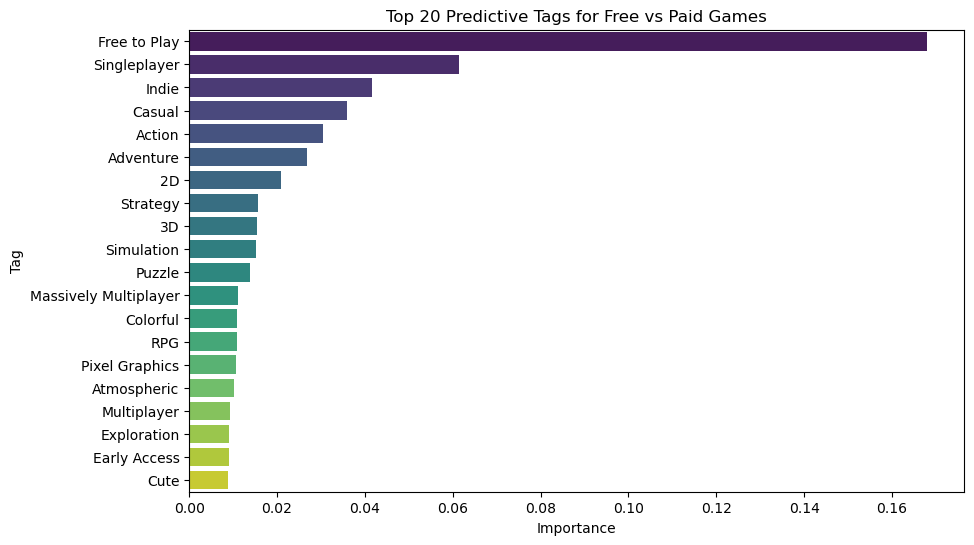

In [48]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


X = tags_encoded  
y = df['is_free'] 


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    random_state=42,
    class_weight='balanced'  # key for Free game prediction
)
rf.fit(X_train, y_train)


y_pred = rf.predict(X_test)


print("Classification Report:\n")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:\n")
print(confusion_matrix(y_test, y_pred))


feat_importances = pd.Series(rf.feature_importances_, index=X.columns)
feat_importances = feat_importances.sort_values(ascending=False).head(20)

print("\nTop 20 tags most predictive of Free vs Paid games:\n")
print(feat_importances)


plt.figure(figsize=(10,6))
sns.barplot(x=feat_importances.values, y=feat_importances.index, palette="viridis")
plt.title("Top 20 Predictive Tags for Free vs Paid Games")
plt.xlabel("Importance")
plt.ylabel("Tag")
plt.show()


In [51]:
print(df.columns)

Index(['Name', 'Date', 'Estimated_Owners_Range', 'Peak CCU', 'Age Required',
       'Price', 'null', 'DiscountDLC count', 'About the game',
       'Supported languages', 'Full audio languages', 'Reviews',
       'Header image', 'Website', 'Support url', 'Support email', 'Windows',
       'Mac', 'Linux', 'Metacritic score', 'Metacritic url', 'User score',
       'Positive', 'Negative', 'Score rank', 'Achievements', 'Recommendations',
       'Notes', 'Average playtime forever', 'Average playtime two weeks',
       'Median playtime forever', 'Median playtime two weeks', 'Developers',
       'Publishers', 'Categories', 'Genres', 'Tags', 'Screenshots', 'Movies',
       'Release_Year', 'is_free'],
      dtype='object')


In [53]:
# Export the DataFrame to CSV
df.to_csv("steam_games.csv", index=False)

print("CSV export complete!")


CSV export complete!


In [54]:
import os

print(os.getcwd())


C:\Users\Xtest.DESKTOP-A1VKC8M
